## SAT solvers

SAT solver is a program that solves boolean satisfiability problem.

Solving boolean satisfiability problem is a fancy way of saying: "find values of boolean variables, such that boolean formula is true".

E.g. boolean formula `X and Y` is true when X is true and Y is true.
The same variable can be encountered many times in a formula (`X and (Y or not X) and (Z or not Y)`). That's why solving boolean satisfiability is a hard problem. No known polynomial algorithm exists.

But there are SAT solvers that use heuristics for optimizations and can give pretty good results even on the formulas with thousand variables. One of these solvers is [PySAT](https://pysathq.github.io)

In [15]:
from pysat.formula import CNF
from pysat.solvers import Solver
import matplotlib.pyplot as plt
%matplotlib inline

PySAT solves boolean problems represented in CNF.

CNF is a fancy way of saying: "Conjunctive normal form".

Conjunction is fancy way of saying: "AND"

Conjunctive normal form looks like `(X or Y or Z) and (not X or T or z)`. Nested clauses can have only `or` and simple negation. Nested clauses are connected via `and`.

In [16]:
def solve(clauses):
    cnf = CNF(from_clauses=clauses)
    with Solver(bootstrap_with=cnf) as solver:
        if solver.solve():
            return solver.get_model()

solve([[1], [2]])  # 1 is a variable, 2 is another variable, this represents `1 AND 2`

[1, 2]

`[1, 2]` means that our boolean formula is true when 1 is true and when 2 is true.

-1 or -2 means negation of variable 1 or 2.

In [3]:
solve([[-1, -2], [1, 2]])  # `(NOT 1 or NOT 2) AND (1 OR 2)

[1, -2]

Many problems can be converted to SAT.

Let's solve [N queens puzzle](https://en.wikipedia.org/wiki/Eight_queens_puzzle) using SAT solver.

In [17]:
import itertools


def less_than(n, variables):
    """
    Generate cnf that is true when less than `n` of variables are true
    """
    neg = [-v for v in variables]
    # let's say we have k true variables and n - k false variables
    # if k < n, then there's no subset in combinatations that includes all true variables, so each
    # subset contains at least one false variable and because of negation this will give us true
    # if k >= n, then there's a subset in combinations that includes all true variables, and this clause will be false
    # because of negations
    # so  if k < n then cnf is true
    # and if k >=n then cnf is false
    # this is exactly what we want
    return list(itertools.combinations(neg, n))


def one_of(variables):
    """
    Generate cnf that is true when exactly 1 variable is true
    """
    # we build cnf such that less than two variables are true AND at least of one the variables is true
    return less_than(2, variables) + [tuple(variables)]
    
one_of(variables=[1, 2])  # this represents XOR

[(-1, -2), (1, 2)]

We represent every square on the chessboard with the boolean variable that is true when it contains a queen. With this representation we just need to solve the formula: each row/verticall should contain exactly 1 queen and each diagonal should contain <= 1 queen. SAT solver can do that for us.

prepared cnf with 800 clauses in 0.00s


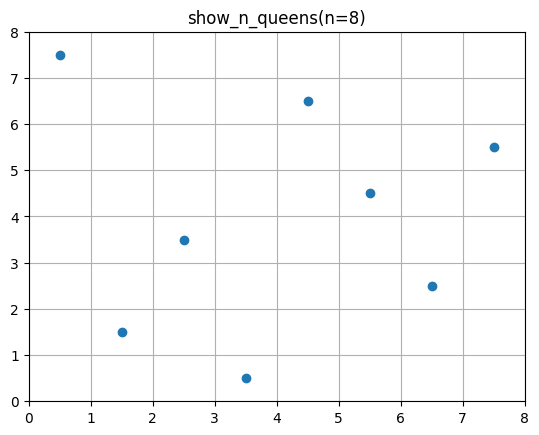

In [22]:
import numpy as np
import time

def to_int_list(array):
    return [int(item) for item in array]

def solve_n_queens(n):
    started_at = time.time()
    variables = np.arange(1, n ** 2 + 1)
    board = variables.reshape(n, n)
    cnf = []
    for i in range(n):
        row = board[i]
        column = board[:,i]
        diagonal1 = np.diagonal(board, offset=i)
        diagonal2 = np.diagonal(board, offset=-i)
        diagonal3 = np.diagonal(np.fliplr(board), offset=i)
        diagonal4 = np.diagonal(np.fliplr(board), offset=-i)
        
        cnf.extend(one_of(variables=to_int_list(row)))
        cnf.extend(one_of(variables=to_int_list(column)))
        cnf.extend(less_than(2, variables=to_int_list(diagonal1)))
        cnf.extend(less_than(2, variables=to_int_list(diagonal2)))
        cnf.extend(less_than(2, variables=to_int_list(diagonal3)))
        cnf.extend(less_than(2, variables=to_int_list(diagonal4)))
    duration = time.time() - started_at
    print(f'prepared cnf with {len(cnf)} clauses in {duration:.2f}s')
    return solve(cnf)


def show_n_queens(n):
    values = solve_n_queens(n)
    if values is None:
        print(f'no solution for show_n_queens({n=})')
        return
    xs = []
    ys = []
    for a_value in values:
        if a_value > 0:
            y, x = divmod(a_value - 1, n)
            xs.append(x + 0.5)
            ys.append(y + 0.5)
    plt.scatter(xs, ys)
    plt.xticks(range(n + 1))
    plt.yticks(range(n + 1))
    plt.grid(True)
    plt.title(f'show_n_queens({n=})')
    plt.show()
    

show_n_queens(8)


In [34]:
def cnf_from_dnf(groups):
    # make a copy, so we can change it later without affecting a caller
    groups = groups.copy()
    
    if not groups:
        return []
    
    if all(len(a_group) == 1 for a_group in groups):
        # dnf([(A), (B)]) => cnf([(A, B)]) <=> A v B = (A v B)
        return [tuple(a_group[0] for a_group in groups)]
    
    groups.sort(key=len, reverse=True)
    # (A ^ B ^ C) v (D ^ E) v (F ^ G) <=> (A v (D ^ E) v (F ^ G)) ^ (B v (D ^ E) v (F ^ G)) ^ (C v (D ^ E) v (F ^ G)))
    first = groups[0]
    rest = groups[1:]
    cnf = []
    for item in first:
        cnf.extend(cnf_from_dnf([[item], *rest]))
    return cnf
    
    
print(f'{cnf_from_dnf([[1], [2]])=}')
print(f'{cnf_from_dnf([[1], [2, 3]])=}')
print(f'{cnf_from_dnf([[1, 2], [3, 4]])=}')
print(f'{cnf_from_dnf([[1, 2], [3, 4], [5, 6]])=}')

cnf_from_dnf([[1], [2]])=[(1, 2)]
cnf_from_dnf([[1], [2, 3]])=[(2, 1), (3, 1)]
cnf_from_dnf([[1, 2], [3, 4]])=[(3, 1), (4, 1), (3, 2), (4, 2)]
cnf_from_dnf([[1, 2], [3, 4], [5, 6]])=[(5, 3, 1), (6, 3, 1), (5, 4, 1), (6, 4, 1), (5, 3, 2), (6, 3, 2), (5, 4, 2), (6, 4, 2)]


sat solvers are very versatile tools and you can solve many hard problems piggybacking on SAT implementations.
E.g to solve 9x9 sudoku you'll have 81*9 variables (for each cell you'll have 9 boolean variables with the meaning cell == 1, cell == 2, ..., cell == 9) and then you just apply constraints with one_of(row==1), one_of(row==2), ... 
one_of(column==1), one_of(column==2), ... one_of(3x3_block == 1), one_of(3x3_block == 1).

The trick in applying SAT solvers to your seemingly unrelated problem is to describe your problem in boolean terms and apply constraints.